In [74]:
import keras 
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import shutil
from keras.utils import to_categorical
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt

from sklearn import metrics

In [75]:
# To create the same dataset
random.seed(0)

base = './'
# Here write the path to your dataset
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]

In [76]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
    
random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))

2595
865
866


In [5]:
for image, label in train_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(train_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in val_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(validation_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in test_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(test_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

In [77]:
# Sanity check 

num_train = 0
num_val = 0 
num_test = 0

for cat in categories: 
    num_train += len(os.listdir(os.path.join(train_dir, cat)))
    num_val += len(os.listdir(os.path.join(validation_dir, cat)))
    num_test += len(os.listdir(os.path.join(test_dir, cat)))
    
assert num_train == len(train_images), 'Sizes must match'
assert num_test == len(test_images), 'Sizes must match'
assert num_val == len(val_images), 'Sizes must match'

In [78]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [79]:
def get_model(): 
    model = models.Sequential()
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    
    return model 

model = get_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 15, 15, 128)     

In [80]:
from keras.models import load_model

model = load_model('own_architecture.h5')

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

In [10]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size = (150, 150), 
        batch_size = 1, 
        class_mode = 'categorical',
        shuffle = False)

Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [15]:
BATCH_SIZE = 20 

In [10]:
train_steps = np.floor(num_train / BATCH_SIZE) + 1
val_steps = np.floor(num_val / BATCH_SIZE) + 1

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=val_steps)

Epoch 1/30
130/130 [==============================] - 45s 345ms/step - loss: 1.3595 - acc: 0.3922 - val_loss: 1.2456 - val_acc: 0.4578
Epoch 2/30
130/130 [==============================] - 45s 348ms/step - loss: 1.1659 - acc: 0.5079 - val_loss: 1.4596 - val_acc: 0.4798
Epoch 3/30
130/130 [==============================] - 45s 347ms/step - loss: 1.1113 - acc: 0.5476 - val_loss: 0.7534 - val_acc: 0.5699
Epoch 4/30
130/130 [==============================] - 46s 355ms/step - loss: 1.0391 - acc: 0.5858 - val_loss: 1.0292 - val_acc: 0.5884
Epoch 5/30
130/130 [==============================] - 47s 361ms/step - loss: 0.9633 - acc: 0.6132 - val_loss: 0.8281 - val_acc: 0.6081
Epoch 6/30
130/130 [==============================] - 52s 398ms/step - loss: 0.9450 - acc: 0.6398 - val_loss: 1.4926 - val_acc: 0.6347
Epoch 7/30
130/130 [==============================] - 46s 354ms/step - loss: 0.9125 - acc: 0.6433 - val_loss: 0.3850 - val_acc: 0.6532
Epoch 8/30
130/130 [==============================] - 4

KeyboardInterrupt: 

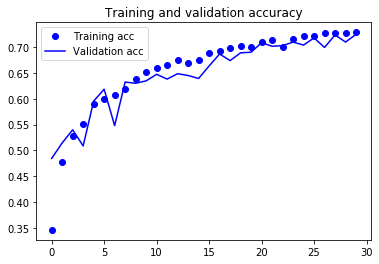

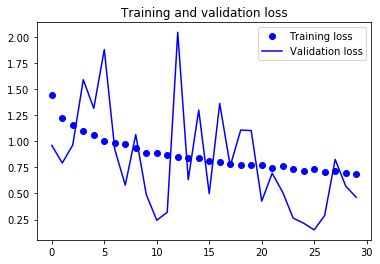

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [81]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict_generator(test_generator, verbose=1), axis=1)

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_true, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_true, y_pred))

865/865 [==============================] - 6s 7ms/step
Classification report for classifier <keras.engine.sequential.Sequential object at 0x157708518>:
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       175
           1       0.90      0.76      0.82       203
           2       0.62      0.84      0.71       158
           3       0.78      0.89      0.83       140
           4       0.80      0.70      0.74       189

    accuracy                           0.79       865
   macro avg       0.80      0.80      0.79       865
weighted avg       0.81      0.79      0.79       865


Confusion matrix:
[[141   3  14   9   8]
 [  8 155  21  13   6]
 [  3   4 132   4  15]
 [  1   8   2 124   5]
 [  2   3  43   9 132]]


## Pre-trained conv net 

In [82]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [83]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_103[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [26]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count, batch_size):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = list(map(np.argmax, labels_batch))
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, num_train - 2, BATCH_SIZE)
validation_features, validation_labels = extract_features(validation_dir, num_val, BATCH_SIZE)
test_features, test_labels = extract_features(test_dir, num_test, 1)

Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [29]:
len(train_features)

2593

In [84]:
train_features = np.reshape(train_features, (len(train_features), 3 * 3 * 2048))
validation_features = np.reshape(validation_features, (len(validation_features), 3 * 3 * 2048))
test_features = np.reshape(test_features, (len(test_features), 3 * 3 * 2048))

In [85]:
y_train = to_categorical(train_labels)
y_val = to_categorical(validation_labels)

In [87]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, y_train,
                    epochs=10,
                    batch_size=20,
                    validation_data=(validation_features, y_val))

Train on 2593 samples, validate on 865 samples
Epoch 1/10
2593/2593 [==============================] - 7s 3ms/step - loss: 1.3397 - acc: 0.5334 - val_loss: 0.7606 - val_acc: 0.7121
Epoch 2/10
2593/2593 [==============================] - 7s 3ms/step - loss: 0.7670 - acc: 0.7235 - val_loss: 0.6474 - val_acc: 0.7699
Epoch 3/10
2593/2593 [==============================] - 8s 3ms/step - loss: 0.6048 - acc: 0.7921 - val_loss: 0.5970 - val_acc: 0.7861
Epoch 4/10
2593/2593 [==============================] - 8s 3ms/step - loss: 0.4897 - acc: 0.8187 - val_loss: 0.5880 - val_acc: 0.7896
Epoch 5/10
2593/2593 [==============================] - 7s 3ms/step - loss: 0.4059 - acc: 0.8592 - val_loss: 0.5590 - val_acc: 0.8058
Epoch 6/10
2593/2593 [==============================] - 7s 3ms/step - loss: 0.3485 - acc: 0.8812 - val_loss: 0.5473 - val_acc: 0.8104
Epoch 7/10
2593/2593 [==============================] - 7s 3ms/step - loss: 0.2896 - acc: 0.8936 - val_loss: 0.5649 - val_acc: 0.8092
Epoch 8/10
2593

In [88]:
y_true = test_labels
y_pred = np.argmax(model.predict(test_features, verbose=1), axis=1)

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_true, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_true, y_pred))

866/866 [==============================] - 0s 318us/step
Classification report for classifier <keras.engine.sequential.Sequential object at 0x160fc05f8>:
              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85       175
         1.0       0.82      0.91      0.86       203
         2.0       0.84      0.78      0.81       158
         3.0       0.79      0.86      0.82       141
         4.0       0.82      0.83      0.82       189

    accuracy                           0.83       866
   macro avg       0.84      0.83      0.83       866
weighted avg       0.84      0.83      0.83       866


Confusion matrix:
[[139  17   3  10   6]
 [  7 184   1   6   5]
 [  3   4 123   6  22]
 [  2   9   7 121   2]
 [  1  10  12  10 156]]


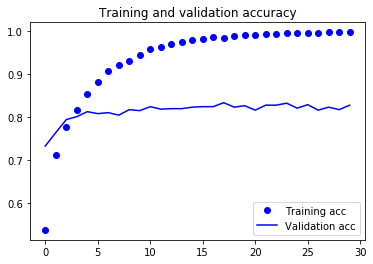

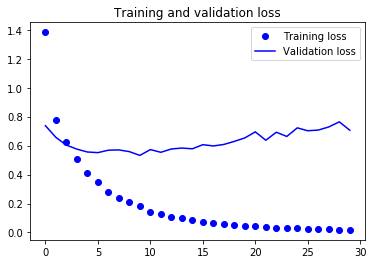

In [40]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [42]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 1285      
Total params: 26,522,917
Trainable params: 26,488,485
Non-trainable params: 34,432
_________________________________________________________________


In [43]:
conv_base.trainable = False

In [46]:
train_steps = np.floor(num_train / BATCH_SIZE) + 1
val_steps = np.floor(num_val / BATCH_SIZE) + 1

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=val_steps)

Epoch 1/30
130/130 [==============================] - 78s 603ms/step - loss: 1.1838 - acc: 0.5280 - val_loss: 3.1381 - val_acc: 0.4173
Epoch 2/30
130/130 [==============================] - 71s 546ms/step - loss: 0.9798 - acc: 0.6209 - val_loss: 2.9034 - val_acc: 0.5168
Epoch 3/30
130/130 [==============================] - 69s 529ms/step - loss: 0.9177 - acc: 0.6637 - val_loss: 2.1992 - val_acc: 0.5746
Epoch 4/30
130/130 [==============================] - 71s 544ms/step - loss: 0.8830 - acc: 0.6695 - val_loss: 0.5831 - val_acc: 0.5942
Epoch 5/30
130/130 [==============================] - 70s 540ms/step - loss: 0.8265 - acc: 0.6895 - val_loss: 2.2221 - val_acc: 0.5283
Epoch 6/30
130/130 [==============================] - 70s 541ms/step - loss: 0.8350 - acc: 0.6911 - val_loss: 1.9038 - val_acc: 0.5792
Epoch 7/30
130/130 [==============================] - 70s 541ms/step - loss: 0.8303 - acc: 0.6984 - val_loss: 0.6149 - val_acc: 0.6243
Epoch 8/30
130/130 [==============================] - 7

In [68]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict_generator(test_generator, verbose=1), axis=1)

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_true, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_true, y_pred))

865/865 [==============================] - 36s 41ms/step


In [71]:
np.mean(y_true == y_pred)

0.6173410404624278

Classification report for classifier <keras.engine.sequential.Sequential object at 0x145e5e4e0>:
              precision    recall  f1-score   support

           0       0.47      0.95      0.63       175
           1       0.86      0.39      0.54       203
           2       0.93      0.41      0.57       158
           3       0.57      0.47      0.52       140
           4       0.67      0.83      0.74       189

    accuracy                           0.62       865
   macro avg       0.70      0.61      0.60       865
weighted avg       0.71      0.62      0.60       865


Confusion matrix:
[[166   1   0   3   5]
 [ 87  80   1  30   5]
 [ 20   2  65  12  59]
 [ 60   4   1  66   9]
 [ 19   6   3   4 157]]
